In [1]:
# autosave every 60 seconds
%autosave 60

# display full output in Notebook, instead of only the last result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import MaxNLocator
import seaborn as sns
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# plt.style.use('fivethirtyeight')
sns.set_style("whitegrid")

# latex font for plots
# plt.rcParams['text.latex.preamble']=[r"\usepackage{lmodern}"]
# #Options
# params = {'text.usetex' : True,
#           'font.size' : 12,
#           'font.family' : 'lmodern',
#           'text.latex.unicode': True,
#           }
# plt.rcParams.update(params) 


# standard libraries
import numpy as np
import pandas as pd
import os
import json
from datetime import datetime, timezone
import time

# make this notebook's output stable across runs
np.random.seed(42)
    
# ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

Autosaving every 60 seconds


# Import Data

In [2]:
# Number of parking Spaces
NUM_PARKING_SPACES = 128

# path
path = '../'

# file names
data_name = 'burgdorf.csv'

# function to import data
def load_data(data_path, data_type, sep):
    csv_path = os.path.join(data_path, data_type)
    return pd.read_csv(csv_path, sep=sep)


# load data
df_burgdorf_raw = pd.read_csv(path + '00_data/01_archive/' + data_name, sep=';',
                            header=None, names=['arrival_unix', 'departure_unix', 'arrival_local', 'departure_local', 'date_test'],
                            skiprows=1, usecols=[2,3,4,5,6])

df_burgdorf_raw.sort_values('arrival_local', inplace=True, ignore_index=True)
print(df_burgdorf_raw[df_burgdorf_raw.departure_local.isna()])

df_burgdorf_raw.dropna(inplace=True)
df_burgdorf_raw.arrival_local = pd.to_datetime(df_burgdorf_raw['arrival_local'])
df_burgdorf_raw.departure_local = pd.to_datetime(df_burgdorf_raw['departure_local'])

df_burgdorf_reference = pd.read_csv(path + '00_data/' + data_name, sep=',')

print('Dataset length of raw data: {}'.format(len(df_burgdorf_raw)))
print('Dataset length of reference data: {}'.format(len(df_burgdorf_reference)))

# print(df_burgdorf_raw)
# print(df_burgdorf_reference)


      arrival_unix  departure_unix        arrival_local departure_local  \
6545    1614101271             NaN  2021-02-23T18:27:51             NaN   
6556    1614105855             NaN  2021-02-23T19:44:15             NaN   
6704    1614238022             NaN  2021-02-25T08:27:02             NaN   
6941    1614352588             NaN  2021-02-26T16:16:28             NaN   
7115    1614513982             NaN  2021-02-28T13:06:22             NaN   
7125    1614523231             NaN  2021-02-28T15:40:31             NaN   
7133    1614540603             NaN  2021-02-28T20:30:03             NaN   

                date_test  
6545  2021-02-23T17:27:51  
6556  2021-02-23T18:44:15  
6704  2021-02-25T07:27:02  
6941  2021-02-26T15:16:28  
7115  2021-02-28T12:06:22  
7125  2021-02-28T14:40:31  
7133  2021-02-28T19:30:03  
Dataset length of raw data: 7137
Dataset length of reference data: 7171


### Process reference

In [3]:
df_burgdorf_reference = df_burgdorf_reference.rename(columns={'category': 'date', 'Auslastung': 'occupancy_rate'})

# add hh:mm artificially for Burgdorf data since raw data does not explicitly provide HH:MM level but is based on HH:MM
# transform 1, 2, ... 23 to 01:00, 02:00 

count = 0
dates = []

for i in range(len(df_burgdorf_reference.date)):
    if count == 23:
        dates.append(str(count)+':00')
        count = 0

    else:
        if count < 10:
            dates.append('{:02d}'.format(count)+':00')
        else:
            dates.append(str(count)+':00')
        count += 1

# join dates list with date only column
df_burgdorf_reference['date'] = df_burgdorf_reference['date'].astype(str) + ' ' + dates
# transform string date column to datetime column
df_burgdorf_reference['date'] = pd.to_datetime(df_burgdorf_reference['date'])

In [4]:
# Prepare empty df for storing the converted occupancies
df_burgdorf_processed = pd.DataFrame({
    'date': pd.date_range(
        df_burgdorf_raw.arrival_local.iloc[0].floor('H'),
        df_burgdorf_raw.sort_values('departure_local', inplace=False).departure_local.iloc[-1].ceil('H'),
        freq='1H'
    )
})

df_burgdorf_processed['occupancy_rate'] = [None] * len(df_burgdorf_processed)

for i in range(0, len(df_burgdorf_processed)):
    start_date = df_burgdorf_processed.date.iloc[i]
    end_date = start_date + pd.Timedelta('1H')

    candidates = df_burgdorf_raw[
        (df_burgdorf_raw.arrival_local < end_date) &
        (df_burgdorf_raw.departure_local > start_date)
    ].copy()
    candidates = candidates[{'arrival_local', 'departure_local'}]

    # print('Querying interval {} - {}'.format(start_date, end_date))
    candidates.loc[(candidates.arrival_local < start_date), 'arrival_local'] = start_date
    candidates.loc[(candidates.departure_local > end_date), 'departure_local'] = end_date
    # print(candidates)

    occupied_seconds = (candidates.departure_local - candidates.arrival_local).sum().seconds
    df_burgdorf_processed.loc[i, 'occupancy_rate'] = 100 * occupied_seconds / (3600 * NUM_PARKING_SPACES)
    # df_burgdorf_processed.loc[i, 'occupancy_rate'] = round(100 * occupied_seconds / (3600 * NUM_PARKING_SPACES), 2)


(18628.0, 18687.0)

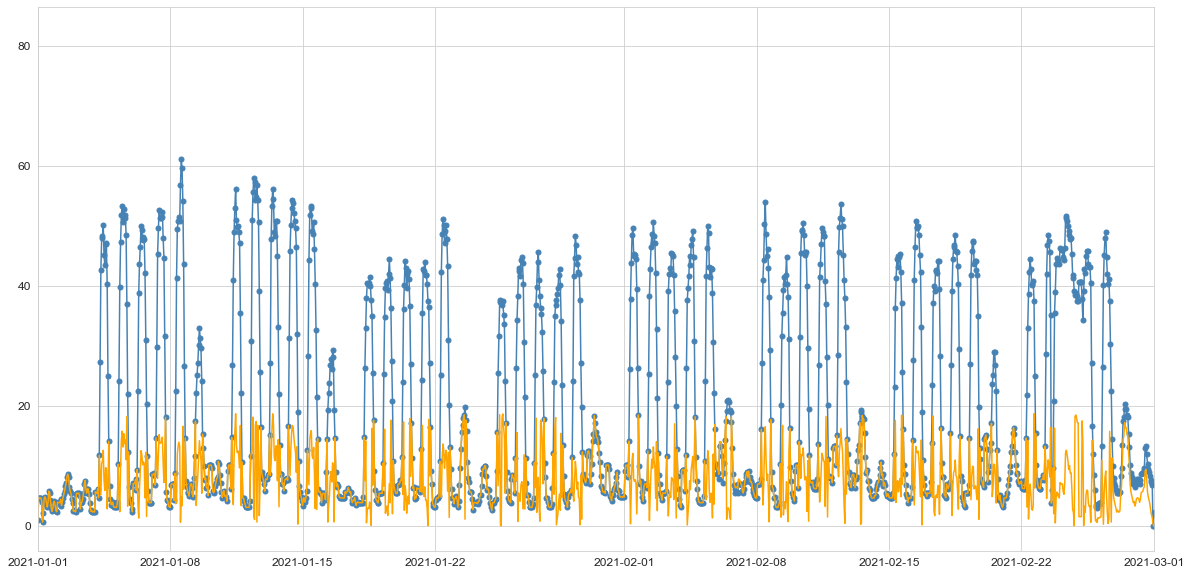

In [7]:
fig = plt.figure(figsize=(20,10));
ax = fig.add_subplot(111);

plt.plot(df_burgdorf_reference.date, df_burgdorf_reference.occupancy_rate, marker=".", markersize=10, color="steelblue");
plt.plot(df_burgdorf_processed.date, df_burgdorf_processed.occupancy_rate, color="orange");
# plt.title('Rapperswil – Average parking occupancy per date (' + str(df_rapperswil.date_only.min().date()) + ' to '
                                        #  + str(df_rapperswil.date_only.max().date()) + ')',
                                        #  fontsize = 16, weight = 'bold');
ax.set_xlim(left=df_burgdorf_processed.date.iloc[0], right=df_burgdorf_processed.date.iloc[-1])

# plt.xlabel('Date', fontsize = 16, weight = 'bold');
# plt.ylabel('Parking occupancy (%)', fontsize = 16, weight = 'bold');
#plt.show();
